# L7a: Singular Value Decomposition (SVD) of the Daily Growth Rate of the S&P500.
In this lab, we'll decompose the daily growth rate values for components of the S&P500 using SVD.
Singular value decomposition helps us break down complex data into simpler, interpretable components.

> **Learning Objectives:** By the end of this example, you will be able to:
>
> * **Apply SVD to Financial Data**: Calculate growth rates from S&P500 stock prices and break down the data matrix using SVD. You'll learn how to use linear algebra to find patterns in financial data.
> * **Understand What the Math Tells Us**: Figure out what the singular values mean and how much of the market behavior each part explains. You'll see the difference between market-wide movements and individual stock changes.
> * **Visualize Market Patterns**: Create pictures of market behavior using the SVD components and spot trends in the data. This helps you see how different stocks move together and identify important time periods in the market.


By applying SVD to the daily growth rates of S&P500 stocks, we can uncover underlying patterns and trends in the market. Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [6]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 515 entries:
  "DD"   => 2329×8 DataFrame…
  "EMR"  => 2767×8 DataFrame…
  "CTAS" => 2767×8 DataFrame…
  "HSIC" => 2767×8 DataFrame…
  "KIM"  => 2767×8 DataFrame…
  "PLD"  => 2767×8 DataFrame…
  "IEX"  => 2767×8 DataFrame…
  "TPR"  => 1803×8 DataFrame…
  "BAC"  => 2767×8 DataFrame…
  "CBOE" => 2767×8 DataFrame…
  "EXR"  => 2767×8 DataFrame…
  "NCLH" => 2767×8 DataFrame…
  "CVS"  => 2767×8 DataFrame…
  "DRI"  => 2767×8 DataFrame…
  "DTE"  => 2767×8 DataFrame…
  "ZION" => 2767×8 DataFrame…
  "AVY"  => 2767×8 DataFrame…
  "EW"   => 2767×8 DataFrame…
  "EA"   => 2767×8 DataFrame…
  "NWSA" => 2767×8 DataFrame…
  "BBWI" => 859×8 DataFrame…
  "CAG"  => 2767×8 DataFrame…
  "GPC"  => 2767×8 DataFrame…
  "FCX"  => 2767×8 DataFrame…
  "GILD" => 2767×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # nrow? (check out: DataFrames.jl)

2767

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [48]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # what is this doing?
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

In [52]:
dataset

Dict{String, DataFrame} with 424 entries:
  "EMR"  => 2767×8 DataFrame…
  "CTAS" => 2767×8 DataFrame…
  "HSIC" => 2767×8 DataFrame…
  "KIM"  => 2767×8 DataFrame…
  "PLD"  => 2767×8 DataFrame…
  "IEX"  => 2767×8 DataFrame…
  "BAC"  => 2767×8 DataFrame…
  "CBOE" => 2767×8 DataFrame…
  "EXR"  => 2767×8 DataFrame…
  "NCLH" => 2767×8 DataFrame…
  "CVS"  => 2767×8 DataFrame…
  "DRI"  => 2767×8 DataFrame…
  "DTE"  => 2767×8 DataFrame…
  "ZION" => 2767×8 DataFrame…
  "AVY"  => 2767×8 DataFrame…
  "EW"   => 2767×8 DataFrame…
  "EA"   => 2767×8 DataFrame…
  "NWSA" => 2767×8 DataFrame…
  "CAG"  => 2767×8 DataFrame…
  "GPC"  => 2767×8 DataFrame…
  "FCX"  => 2767×8 DataFrame…
  "GILD" => 2767×8 DataFrame…
  "UNP"  => 2767×8 DataFrame…
  "CDW"  => 2767×8 DataFrame…
  "SBUX" => 2767×8 DataFrame…
  ⋮      => ⋮

How many firms do we have the full number of trading days? Let's use [the `length(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.length) - notice this works for dictionaries, in addition to arrays, sets and other collections.

In [12]:
length(dataset) # tells us how many keys are in the dictionary (how many firms in our dataset?)

424

Finally, let's get a list of the firms in our cleaned up dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [14]:
list_of_tickers = keys(dataset) |> collect |> sort # list of firm "ticker" symbols in alphabetical order

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

In [15]:
dataset["AMD"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,2.29227e7,3.9534,3.98,4.0,4.0,3.88,2014-01-03T05:00:00,28717
2,4.24307e7,4.1101,4.01,4.13,4.18,3.99,2014-01-06T05:00:00,46748
3,4.29636e7,4.1944,4.19,4.18,4.25,4.11,2014-01-07T05:00:00,45097
4,3.06961e7,4.2113,4.23,4.18,4.26,4.14,2014-01-08T05:00:00,42975
5,3.06921e7,4.1259,4.2,4.09,4.23,4.05,2014-01-09T05:00:00,37844
6,2.08901e7,4.1337,4.09,4.17,4.2,4.07,2014-01-10T05:00:00,27426
7,2.28843e7,4.1432,4.19,4.13,4.2,4.09,2014-01-13T05:00:00,30910
8,4.23736e7,4.2454,4.14,4.3,4.3,4.13,2014-01-14T05:00:00,45914
9,6.66734e7,4.4939,4.34,4.47,4.6,4.32,2014-01-15T05:00:00,77015


___

## Task 1: Compute the growth rate matrix
In this task, we compute the growth rate array which contains, for each day and each firm in our dataset, the value of the growth rate between time $j$ and $j-1$. 

>  __Continuously Compounded Growth Rate (CCGR)__
>
> Let's assume a model of the share price of firm $i$ is governed by an expression of the form:
>$$
\begin{align*}
S^{(i)}_{j} &= S^{(i)}_{j-1}\;\exp\left(g^{(i)}_{j,j-1}\Delta{t}_{j}\right)
\end{align*}
$$
> where $S^{(i)}_{j-1}$ denotes the share price of firm $i$ at time index $j-1$, $S^{(i)}_{j}$ denotes the share price of firm $i$ at time index $j$, and $\Delta{t}_{j} = t_{j} - t_{j-1}$ denotes the length of a time step (units: years) between time index $j-1$ and $j$. The value we are going to estimate is the growth rate $g^{(i)}_{j,j-1}$ (units: inverse years) for each firm $i$, and each time step in the dataset.

We've implemented [the `log_growth_rate(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned up dataset, and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

In [54]:
growth_rate_array = let

    # initialize -
    τ = (1/252); # time-step one-day in units of years (trading year is 252 days)
    r̄ = 0.0; # assume the risk-free rate is 0

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = τ, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end

2766×424 Matrix{Float64}:
 -0.877554    6.28105    -2.87097     …  -0.755391   0.245894  -1.00527
  2.81626     1.07149     1.39239         2.13832   -0.80279    0.986468
  3.31305     0.855597    0.00536803      0.109877   1.191     -2.58144
  0.646425   17.2599      1.69215         0.274716   3.1593    -0.368228
  1.81609     2.57961     3.31924         0.621677  -2.1687     4.40309
  0.61383    -3.96384    -0.79278     …  -0.862739  -1.90977   -3.11624
  2.86071    -0.483751    4.84573         1.7657    -1.77685   -1.0896
  2.04671     1.0135      1.90809         1.67597    4.44984   -0.137819
  1.31289     1.67413     0.107259       -1.50708   -2.13696    1.43784
  1.22016     6.12957     0.932578       -1.53202    2.87784   -1.43626
 -0.437668    4.87009     1.00774     …  -0.321261   9.50827   -3.00873
  1.36281     3.61317    -2.34776         0.710613   4.52223    0.340531
 -4.73904     1.38585    -3.01624        -2.15245   -6.64907    1.40612
  ⋮                                

> **Growth Rate Matrix Structure**
>
> The `growth_rate_array` is a matrix $\mathbf{G} \in \mathbb{R}^{m \times n}$ where each **row** represents a trading day (time step) in our dataset, each **column** represents a firm from the S&P500, and each **element** $G_{i,j}$ contains the continuously compounded growth rate for firm $j$ on day $i$.

The matrix has 424 firms (columns) and there are $T-1$ = 2,766 trading days (rows), capturing the daily growth rate dynamics of the S&P500 components from 2014 to 2024. Is there redundancy in the data?

Let's check the rank of the growth rate array using [the `rank(...)` function](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.rank):

In [20]:
rank(growth_rate_array)

424

The growth rate matrix has **full column rank** (rank = 424), which means that all 424 firms contribute independent information to the dataset. 

> __Why is this significant?__ This tells us that no firm's growth pattern can be perfectly predicted from the others. Each stock brings unique behavior to the market, even though there may be strong correlations between them.

Let's dig deeper into the market behavior using SVD!
___

## Task 2: Let's decompose the growth matrix using SVD
In this task, we decompose the growth rate matrix using Singular Value Decomposition (SVD). Let the growth rate matrix be denoted by $\mathbf{G} \in \mathbb{R}^{m\times n}$, where $m$ is the number of time steps (days) in our dataset, and $n$ is the number of firms in our dataset. The SVD of $\mathbf{G}$ is given by:
$$
\begin{align*}
\mathbf{G} &= \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}
\end{align*}
$$
where $\mathbf{U} \in \mathbb{R}^{m\times m}$ is a matrix whose columns are the left singular vectors of $\mathbf{G}$, $\mathbf{\Sigma} \in \mathbb{R}^{m\times n}$ is a diagonal matrix whose diagonal entries are the singular values of $\mathbf{G}$, and $\mathbf{V} \in \mathbb{R}^{n\times n}$ is a matrix whose columns are the right singular vectors of $\mathbf{G}$.

> __Why SVD?__
>
> SVD is a powerful tool for analyzing the structure of data. It can be used for dimensionality reduction, noise reduction, and feature extraction. In the context of financial data, SVD can help us identify underlying patterns and trends in the growth rates of different firms.

> __What is SVD?__
>
> Singular value decomposition (SVD) can be thought of as decomposing a matrix into a weighted, ordered sum of separable matrices, e.g., frames of market behavior. Let $\mathbf{A}\in\mathbb{R}^{m\times{n}}$ have the singular value decomposition $\mathbf{G} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{T}$. Then, the matrix $\mathbf{G}\in\mathbb{R}^{m\times{n}}$ can be written as:
> $$
\begin{align*}
\mathbf{G} &= \sum_{i=1}^{r_{\mathbf{G}}}\sigma_{i}\;\underbrace{\left(\mathbf{u}_{i}\otimes\mathbf{v}_{i}\right)}_{\mathbf{G}_{i}}
\end{align*}    
$$
> where $r_{\mathbf{G}}$ is the __rank__ of matrix $\mathbf{G}$, the vectors $\mathbf{u}_{i}$ and $\mathbf{v}_{i}$ are the ith left and right singular vectors, and $\sigma_{i}$ are the ordered singular values. The [outer product](https://en.wikipedia.org/wiki/Outer_product) $\mathbf{G}_{i} = \left(\mathbf{u}_{i}\otimes\mathbf{v}_{i}\right)$ is the separable component of the matrix $\mathbf{G}$ that has rank one. Thus, we are rebuilding the matrix $\mathbf{G}$ as a weighted sum of rank one matrices. The weights are the singular values $\sigma_{i}$. The singular values are ordered from largest to smallest, so the first few terms in the sum capture the most important features of the matrix $\mathbf{G}$. 

This is the basis for data reduction using SVD. By truncating the sum after a few terms, we can obtain a low-rank approximation of the matrix $\mathbf{G}$ that captures the most important features of the data.

We'll use the [`svd(...)` method exported from the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.SVD) to compute the singular value decomposition of `growth_rate_array::Array{Float64,2}`. 

This produces the `U`, `Σ`, and `V` matrices, holding the left singular vectors, the singular values, and the right singular vectors, respectively.

In [56]:
U,S,V = svd(growth_rate_array); # note the transpose

In [62]:
S

424-element Vector{Float64}:
 2824.136438886882
 1056.3669635967708
  913.7849313535669
  831.1162125237141
  784.1430677584597
  709.2446980206777
  597.343738389357
  555.8729479806253
  543.6073934201336
  528.8588083262764
  515.5171520579943
  481.0033831583613
  453.086829662304
    ⋮
   48.19386569337561
   47.425738980156034
   46.796583740068364
   45.766880115002266
   45.335687829279586
   44.98572111967692
   41.216587879144576
   40.29630222835778
   28.53376628617023
   23.900206708442838
   23.62132355503547
   11.83269496058466

One of the cool things about [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) is that modes (the rank one components) are sorted and weighted by the singular values. Thus, we can compute the contribution of each mode by looking at the singular values.

Let's compute and visualize how much information, i.e., what fraction of the original matrix, is explained by each mode by looking at the cumulative sum.

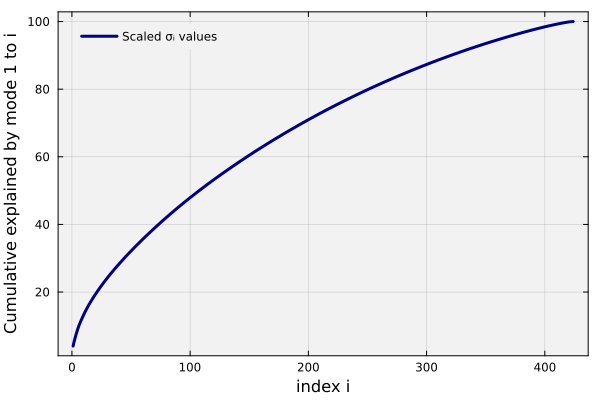

In [25]:
let
    
    # make a plot of the fractional contribution of the singular values
    number_of_modes = length(S);
    SS = (1/sum(S))*S;
    explained_array = [100*sum(SS[1:i]) for i ∈ 1:number_of_modes]; # comprehension

    plot(explained_array, label="Scaled σᵢ values", lw=3, c=:navy)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("index i", fontsize=18)
    ylabel!("Cumulative explained by mode 1 to i", fontsize=18)
end

### What do the singular values tell us about the market behavior?

Looking at the plot above, we can see how the cumulative explained variance grows as we include more SVD modes. The shape of this curve reveals important characteristics about the structure of financial market data.

> **Key Insight**: The S&P500 growth rate data shows that approximately 100 modes (about 25% of the total) are required to capture just 50% of the market behavior. Unlike some physical systems where a few dominant modes capture most behavior, this data suggests stock market dynamics are distributed across many different factors, reflecting the intricate web of economic forces, individual company performance, and investor behavior that drive market movements.

Next, let's visualize the first few modes to see what they tell us about market behavior.
___

## Task 3: Visualize the contribution of each mode
In this task, we visualize the contribution of each mode to the original growth rate matrix by computing the cumulative sum of the weighted rank one updates.

In the visualization below, we'll reconstruct and display the market behavior using up to a specified number of modes. This shows how we can build up approximations of the original data matrix using progressively more components.

> **Visualization Approach**: We're creating grayscale images from the SVD components where each rank-1 matrix $\mathbf{G}_i = \sigma_i \mathbf{u}_i \mathbf{v}_i^T$ represents one "mode" of market behavior. By converting the numerical growth rate values to color intensities (dark = negative, gray = moderate positive, light = large positive), we can visually see patterns in both time (horizontal direction) and across different stocks (vertical direction).

We store the individual market modes in the `image_frames_dictionary::Dict{Int64,Array{Float64,2}}` dictionary variable, where the key is the mode index, and the values are the corresponding reconstructed growth rate matrices.

In [66]:
image_frames_dictionary = let

    # initialize -
    image_frames_dictionary = Dict{Int64,Matrix{Gray{Float64}}}();

    R = rank(growth_rate_array); # how many frames will we have?
    foreach(i -> image_frames_dictionary[i] = S[i]*⊗(U[:,i],V[:,i]), 1:R); # another iteration pattern???

    image_frames_dictionary; # return
end;

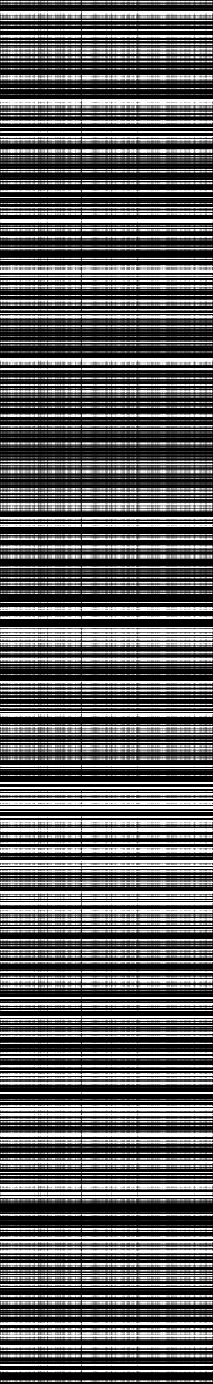

In [68]:
image_frames_dictionary[1]

`Unhide` the code cell below to see how we computed and then visualized the cumulative contribution of each market mode. We've visualized the transpose of the growth rate matrix, so that time is on the horizontal axis, and firms are on the vertical axis.
> __Colors__: Dark values (black) indicate negative growth rates, gray values indicate moderate positive growth rates (between 0% and 5%), and light values (white) indicate large positive growth rates (greater than 5% per year).

So, do we see any interesting patterns in the modes of market behavior?

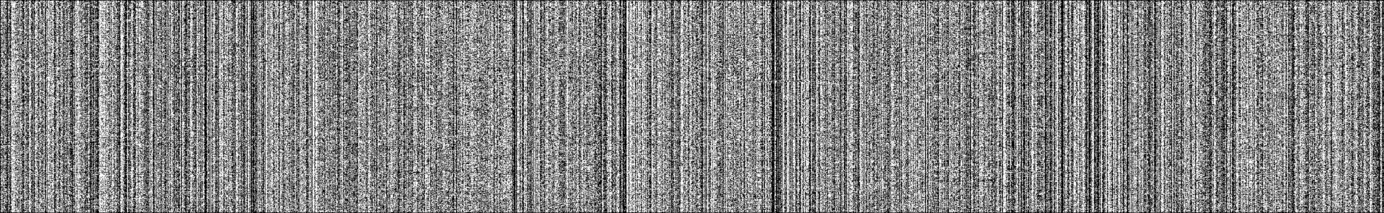

In [74]:
let 
    
    (number_of_trading_days, number_of_firms) = size(growth_rate_array);
    B = zeros(number_of_trading_days, number_of_firms); # initialize

    M = image_frames_dictionary[1];
    number_of_frames = 424;
    for i ∈ 2:number_of_frames
        M += image_frames_dictionary[i]
    end

    for i ∈ 1:number_of_trading_days
        for j ∈ 1:number_of_firms
            if (M[i,j] < 0.0)
                B[i,j] = 0.0; # dark
            elseif (0.0 < M[i,j] < 0.05)
                B[i,j] = 0.5; # gray
            else
                B[i,j] = 1.0; # light
            end
        end
    end

    Gray.(transpose(B)) # rows are firms; columns are trading days
end

`Unhide` the code cell below to see how we visualized the entire market behavior using all modes.
> __Colors__: Dark values (black) indicate negative growth rates, gray values indicate moderate positive growth rates (between 0% and 5%), and light values (white) indicate large positive growth rates (greater than 5% per year).

How does the entire market behavior look when we use all modes?

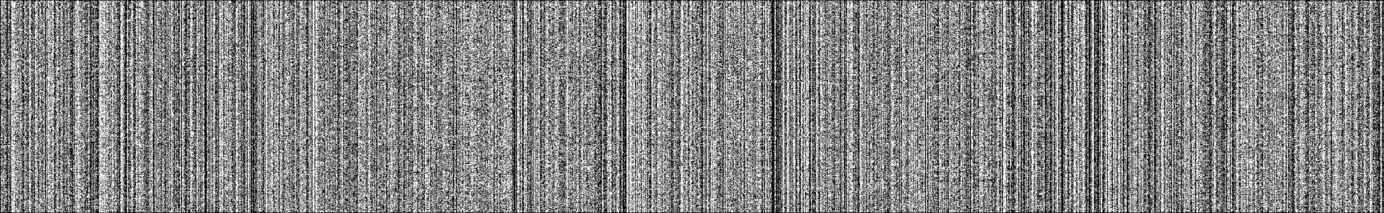

In [32]:
let

    # initialize -
    (number_of_trading_days, number_of_firms) = size(growth_rate_array);
    B = zeros(number_of_trading_days, number_of_firms); # initialize

    for i ∈ 1:number_of_trading_days
        for j ∈ 1:number_of_firms
            if (growth_rate_array[i,j] < 0.0)
                B[i,j] = 0.0; # dark
            elseif (0.0 < growth_rate_array[i,j] < 0.05)
                B[i,j] = 0.5; # gray
            else
                B[i,j] = 1.0; # light
            end
        end
    end

    Gray.(transpose(B)) # rows are firms; columns are trading days
end

### What patterns do we see in the market behavior?

Looking at the grayscale visualizations, we can observe several clear patterns in how the growth rates are distributed across time and firms.

> **Observable Patterns**: The visualizations show distinct vertical bands (time periods where most stocks moved in the same direction) and horizontal bands (groups of stocks that tend to move together). Dark vertical stripes indicate days when many firms experienced negative growth simultaneously, while light areas show periods of broad positive growth. The horizontal patterns suggest that certain groups of firms have correlated behavior.

These visual patterns demonstrate that the SVD decomposition is successfully identifying structure in what might otherwise appear to be random market data. Pretty cool, right?
___